## Titanic Survival Prediction
### Exploratory Data Analysis and Machine Learning

### 1. Problem Statement

The Titanic dataset contains passenger-level information from the RMS Titanic disaster.  
The objective is to build a machine learning model that predicts whether a passenger survived the disaster based on demographic, socio-economic, and travel-related features.

This notebook follows a structured data science workflow:
- Data understanding and cleaning
- Exploratory Data Analysis (EDA)
- Feature engineering
- Predictive modeling
- Model evaluation and inference

The analysis emphasizes interpretability and reproducibility, with the goal of producing a portfolio-quality machine learning project suitable for real-world review.


### 2. Dataset Overview

The dataset is sourced from Kaggle: *Titanic – Machine Learning from Disaster*.

It consists of two files:
- `train.csv`: Includes passenger features and survival labels
- `test.csv`: Includes passenger features without survival labels

For exploratory analysis, both datasets will be merged into a single dataset.  
Before modeling, the merged dataset will be split back into training and test sets.


### 3. Data Loading and Initial Setup


In [145]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import roc_curve

from sklearn.model_selection import cross_validate
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


pd.set_option("display.max_columns", None)
sns.set_style("whitegrid")


In [146]:
# Load datasets
train_df = pd.read_csv("dataset/train.csv")
test_df = pd.read_csv("dataset/test.csv")

# Add dataset identifier
train_df["dataset_source"] = "train"
test_df["dataset_source"] = "test"

# Merge datasets for EDA
full_df = pd.concat([train_df, test_df], ignore_index=True)

# Standardize column names
full_df.columns = full_df.columns.str.lower()

full_df.head()


,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,dataset_source
0,1,0.0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S,train
1,2,1.0,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C,train
2,3,1.0,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,train
3,4,1.0,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S,train
4,5,0.0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S,train


In [147]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   passengerid     1309 non-null   int64  
 1   survived        891 non-null    float64
 2   pclass          1309 non-null   int64  
 3   name            1309 non-null   object 
 4   sex             1309 non-null   object 
 5   age             1046 non-null   float64
 6   sibsp           1309 non-null   int64  
 7   parch           1309 non-null   int64  
 8   ticket          1309 non-null   object 
 9   fare            1308 non-null   float64
 10  cabin           295 non-null    object 
 11  embarked        1307 non-null   object 
 12  dataset_source  1309 non-null   object 
dtypes: float64(3), int64(4), object(6)
memory usage: 133.1+ KB


In [148]:
full_df.describe(include="all")

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,dataset_source
count,1309.000000,891.000000,1309.000000,1309,1309,1046.000000,1309.000000,1309.000000,1309,1308.000000,295,1307,1309
unique,NaN,NaN,NaN,1307,2,NaN,NaN,NaN,929,NaN,186,3,2
top,NaN,NaN,NaN,"Connolly, Miss. Kate",male,NaN,NaN,NaN,CA. 2343,NaN,C23 C25 C27,S,train
freq,NaN,NaN,NaN,2,843,NaN,NaN,NaN,11,NaN,6,914,891
mean,655.000000,0.383838,2.294882,NaN,NaN,29.881138,0.498854,0.385027,NaN,33.295479,NaN,NaN,NaN
std,378.020061,0.486592,0.837836,NaN,NaN,14.413493,1.041658,0.865560,NaN,51.758668,NaN,NaN,NaN
min,1.000000,0.000000,1.000000,NaN,NaN,0.170000,0.000000,0.000000,NaN,0.000000,NaN,NaN,NaN
25%,328.000000,0.000000,2.000000,NaN,NaN,21.000000,0.000000,0.000000,NaN,7.895800,NaN,NaN,NaN
50%,655.000000,0.000000,3.000000,NaN,NaN,28.000000,0.000000,0.000000,NaN,14.454200,NaN,NaN,NaN
75%,982.000000,1.000000,3.000000,NaN,NaN,39.000000,1.000000,0.000000,NaN,31.275000,NaN,NaN,NaN


### Initial Observations

- The dataset contains both numerical and categorical variables.
- Several columns contain missing values, notably `age`, `cabin`, and `embarked`.
- The target variable `survived` is only present for training data.
- Socio-economic status is captured through `pclass` and `fare`.
- Family structure is represented using `sibsp` and `parch`.

These observations guide the subsequent data cleaning and feature engineering steps.


### 4. Data Cleaning

### 4.1 Missing Value Analysis

Before performing any imputations or transformations, it is essential to understand the extent and pattern of missing values across the dataset.

This step helps determine:
- Which variables require imputation
- Which variables can be safely transformed
- Whether missingness itself may carry predictive signal


In [149]:
missing_summary = (
    full_df.isnull()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_Percentage=lambda x: x["missing_count"] / len(full_df) * 100)
    .sort_values("missing_Percentage", ascending=False)
)

missing_summary


,missing_count,missing_Percentage
cabin,1014,77.463713
survived,418,31.932773
age,263,20.091673
embarked,2,0.152788
fare,1,0.076394
passengerid,0,0.000000
pclass,0,0.000000
name,0,0.000000
sex,0,0.000000
sibsp,0,0.000000


### Missing Data Observations

- `cabin` has a high proportion of missing values, which is expected due to historical record limitations.
- `age` contains a moderate number of missing values and requires careful imputation.
- `embarked` has very few missing values and can be imputed using the most frequent category.
- `fare` contains missing values only in the test portion of the dataset.
- Other variables are largely complete.

Rather than dropping high-missing columns such as `cabin`, we retain them because missingness may reflect socio-economic status and access to accommodations.


### 4.2 Target Variable (`survived`)

The target variable `survived` is available only for passengers in the training dataset.
It will not be used during EDA-driven imputations that could introduce data leakage.

Missing values in `survived` correspond exclusively to the test dataset and will be preserved until modeling.


In [150]:
full_df["survived"].value_counts(dropna=False)

survived
0.0    549
NaN    418
1.0    342
Name: count, dtype: int64

In [151]:
len(full_df)

1309

In [152]:
full_df["embarked"].value_counts()

embarked
S    914
C    270
Q    123
Name: count, dtype: int64

In [153]:
most_frequent_embarked = full_df["embarked"].mode()[0]
full_df["embarked"] = full_df["embarked"].fillna(most_frequent_embarked)

### 4.4 Handling `fare`

The `fare` feature represents the ticket price paid by a passenger.
Missing values appear only in the test dataset.

Because fare is right-skewed, the median is a more robust imputation strategy than the mean.


In [154]:
full_df[full_df['fare'].isnull()]

,passengerid,survived,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,dataset_source
1043,1044,NaN,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,NaN,S,test


In [155]:
med_fare = full_df.groupby(['pclass', 'parch', 'sibsp']).fare.median()[3][0][0]
print(med_fare)
full_df['fare'] = full_df['fare'].fillna(med_fare)

7.8542


### 4.5 Handling `age`

Age is a critical demographic feature with a moderate number of missing values.
Since age distributions differ by passenger class and title, more advanced imputation strategies are possible.

At this stage, median imputation is applied to avoid data leakage.
Further refinement will be addressed during feature engineering.


In [156]:
full_df['age'] = full_df.groupby(['sex', 'pclass'])['age'].transform(
    lambda x: x.fillna(x.median())
)

### 4.6 Handling `cabin`

The `cabin` feature has a large number of missing values, but it carries valuable information related to passenger location and socio-economic status.

Instead of imputing cabin numbers, the following strategy is applied:
- Extract the first letter of the cabin as `cabin_deck`
- Treat missing cabins as a separate category

This preserves signal without introducing noise or incorrect assumptions.


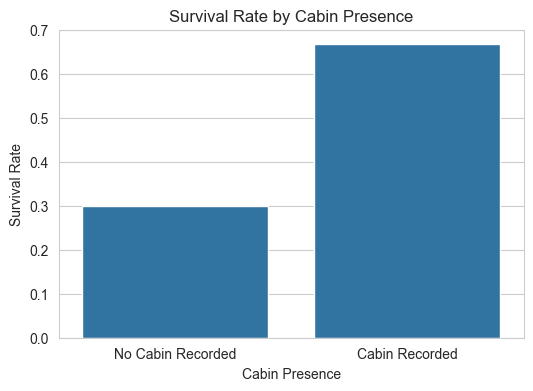

In [157]:
# Temporary feature for analysis
full_df["has_cabin"] = full_df["cabin"].notnull().astype(int)

plt.figure(figsize=(6,4))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="has_cabin",
    y="survived",
    errorbar=None
)
plt.xticks([0, 1], ["No Cabin Recorded", "Cabin Recorded"])
plt.xlabel("Cabin Presence")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Cabin Presence")
plt.show()


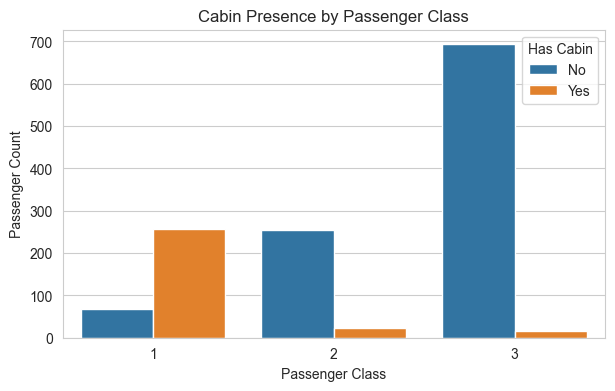

In [158]:
plt.figure(figsize=(7,4))
sns.countplot(
    data=full_df,
    x="pclass",
    hue="has_cabin"
)
plt.xlabel("Passenger Class")
plt.ylabel("Passenger Count")
plt.title("Cabin Presence by Passenger Class")
plt.legend(title="Has Cabin", labels=["No", "Yes"])
plt.show()


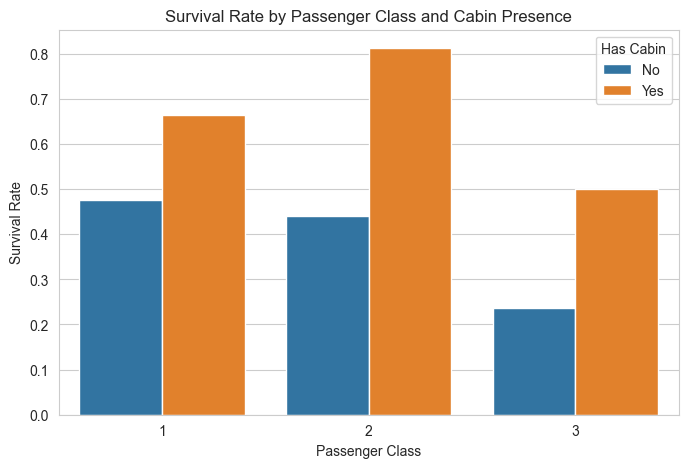

In [195]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="pclass",
    y="survived",
    hue="has_cabin",
    errorbar=None
)
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Passenger Class and Cabin Presence")
plt.legend(title="Has Cabin", labels=["No", "Yes"])
plt.show()


In [160]:
# Final cabin features
full_df["has_cabin"] = full_df["cabin"].notnull().astype(int)
full_df["cabin_deck"] = full_df["cabin"].str[0]

# Drop raw cabin column
full_df = full_df.drop(columns=["cabin"])


### 4.8 Post-Cleaning Validation

After cleaning and transformation, the dataset is checked again to ensure that:
- No unintended missing values remain
- All features are in a modeling-ready state


In [161]:
full_df.isnull().sum()

passengerid          0
survived           418
pclass               0
name                 0
sex                  0
age                  0
sibsp                0
parch                0
ticket               0
fare                 0
embarked             0
dataset_source       0
has_cabin            0
cabin_deck        1014
dtype: int64

## 5. Exploratory Data Analysis (EDA)

This section explores relationships between passenger attributes and survival outcomes.
The objective is to identify meaningful patterns, validate assumptions, and inform feature engineering and model selection.


### 5.1 Target Variable: Survival

We begin by analyzing the distribution of the target variable to understand class balance and baseline prediction difficulty.


In [162]:
survival_counts = (
    full_df[full_df["dataset_source"] == "train"]["survived"]
    .value_counts(normalize=True)
)

survival_counts


survived
0.0    0.616162
1.0    0.383838
Name: proportion, dtype: float64

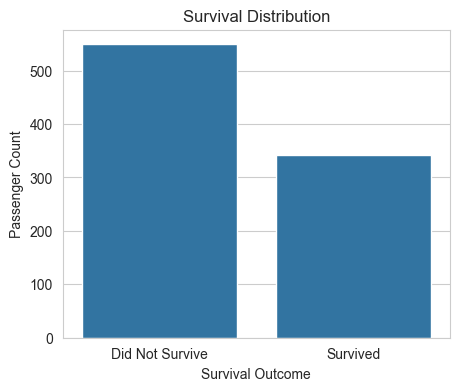

In [163]:
plt.figure(figsize=(5,4))
sns.countplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="survived"
)
plt.xticks([0,1], ["Did Not Survive", "Survived"])
plt.xlabel("Survival Outcome")
plt.ylabel("Passenger Count")
plt.title("Survival Distribution")
plt.show()


The dataset exhibits a moderate class imbalance, with more passengers not surviving than surviving.
This imbalance is not severe but should be considered during model evaluation, particularly when selecting evaluation metrics.


### 5.2 Categorical Variables

Categorical features capture demographic and socio-economic attributes that strongly influence survival.
The following variables are analyzed:
- `sex`
- `pclass`
- `embarked`
- `cabin_deck`


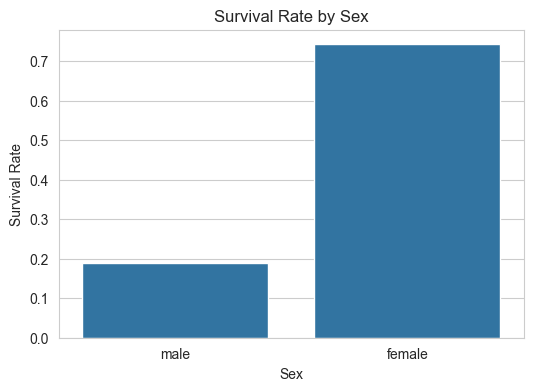

In [164]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="sex",
    y="survived",
    errorbar=None
)
plt.xlabel("Sex")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Sex")
plt.show()


**Interpretation**

Female passengers show a substantially higher survival rate than male passengers.
This aligns with historical evacuation policies and indicates that `sex` is a strong predictor of survival.


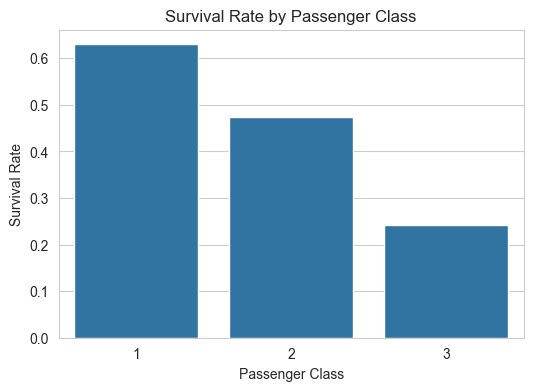

In [165]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="pclass",
    y="survived",
    errorbar=None
)
plt.xlabel("Passenger Class")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Passenger Class")
plt.show()


**Interpretation**

Survival rates decrease monotonically from first class to third class.
Passenger class captures socio-economic differences and access to safety measures, making it a key explanatory feature.


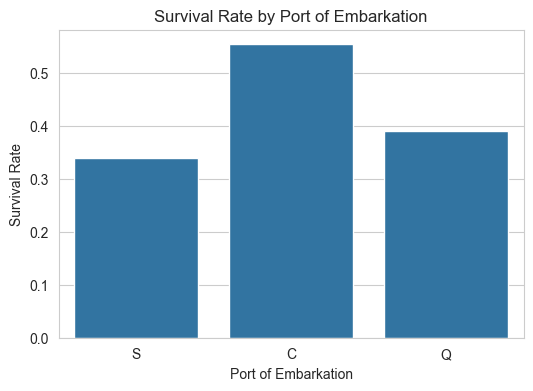

In [194]:
plt.figure(figsize=(6,4))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="embarked",
    y="survived",
    errorbar=None
)
plt.xlabel("Port of Embarkation")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Port of Embarkation")
plt.show()


**Interpretation**

Passengers embarking from Cherbourg show higher survival rates compared to other ports.
This effect likely reflects differences in passenger class distribution across embarkation points.


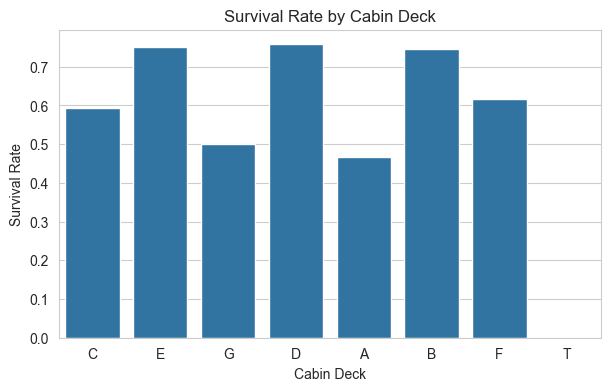

In [196]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=full_df[
        (full_df["dataset_source"] == "train") &
        (full_df["cabin_deck"].notnull())
    ],
    x="cabin_deck",
    y="survived",
    errorbar=None
)
plt.xlabel("Cabin Deck")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Cabin Deck")
plt.show()


**Interpretation**

Survival rates vary meaningfully across cabin decks.
Higher decks generally correspond to better survival outcomes, supporting the hypothesis that physical location influenced evacuation success.


### 5.3 Numerical Variables

Numerical features provide continuous information related to age, family structure, and ticket cost.
The following variables are analyzed:
- `age`
- `fare`
- `sibsp`
- `parch`


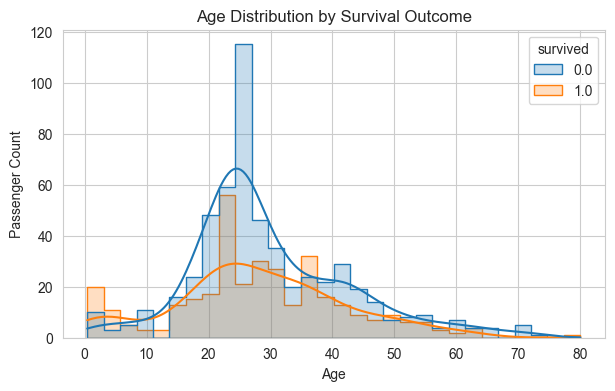

In [168]:
plt.figure(figsize=(7,4))
sns.histplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="age",
    hue="survived",
    bins=30,
    kde=True,
    element="step"
)
plt.xlabel("Age")
plt.ylabel("Passenger Count")
plt.title("Age Distribution by Survival Outcome")
plt.show()


**Interpretation**

Children exhibit higher survival rates, while older passengers show lower survival probabilities.
Age is a non-linear predictor and may benefit from binning or interaction features.


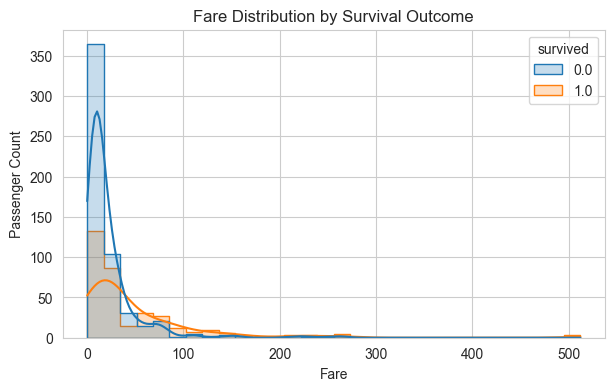

In [169]:
plt.figure(figsize=(7,4))
sns.histplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="fare",
    hue="survived",
    bins=30,
    kde=True,
    element="step"
)
plt.xlabel("Fare")
plt.ylabel("Passenger Count")
plt.title("Fare Distribution by Survival Outcome")
plt.show()


**Interpretation**

Surviving passengers generally paid higher fares.
Fare is right-skewed and reflects socio-economic status, suggesting potential benefit from log transformation.


C:\Users\Gokul Ananth\AppData\Local\Temp\ipykernel_5728\3409420018.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


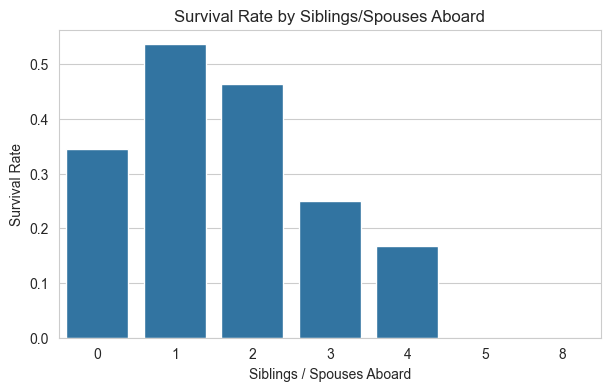

In [ ]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="sibsp",
    y="survived",
    errorbar=None
)
plt.xlabel("Siblings / Spouses Aboard")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Siblings/Spouses Aboard")
plt.show()


C:\Users\Gokul Ananth\AppData\Local\Temp\ipykernel_5728\1673641364.py:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(


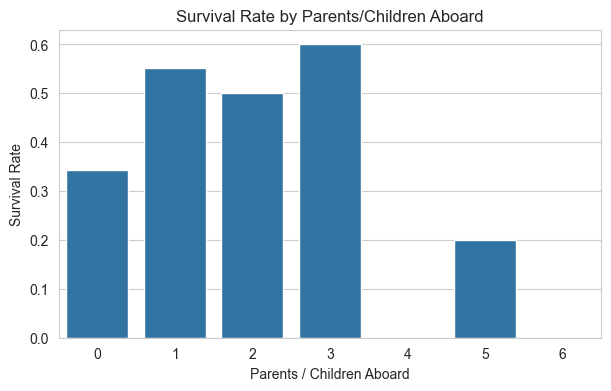

In [171]:
plt.figure(figsize=(7,4))
sns.barplot(
    data=full_df[full_df["dataset_source"] == "train"],
    x="parch",
    y="survived",
    ci=None
)
plt.xlabel("Parents / Children Aboard")
plt.ylabel("Survival Rate")
plt.title("Survival Rate by Parents/Children Aboard")
plt.show()


**Interpretation**

Passengers traveling alone or with small families show higher survival rates.
Large family groups may have faced coordination challenges during evacuation.


### EDA Summary

Key findings from exploratory analysis:
- Survival is strongly influenced by sex, passenger class, and cabin-related features
- Socio-economic indicators consistently correlate with survival outcomes
- Age and fare show non-linear relationships with survival
- Family structure affects survival in a non-monotonic manner

These insights directly inform feature engineering and model selection decisions.


## 6. Feature Engineering

Feature engineering transforms raw variables into representations that better capture underlying patterns observed during EDA.

All transformations are guided by:
- Exploratory findings
- Domain knowledge
- Model interpretability
- Avoidance of target leakage


### 6.1 Title Extraction from `name`

Passenger titles capture social hierarchy, age group, and marital status.
These attributes influenced evacuation priority and survival probability.

Titles are extracted from passenger names and rare titles are grouped to reduce sparsity.


In [172]:
# Extract title from name
full_df["title"] = (
    full_df["name"]
    .str.extract(r",\s*([^\.]+)\.", expand=False)
    .str.strip()
)

full_df["title"].value_counts()


title
Mr              757
Miss            260
Mrs             197
Master           61
Rev               8
Dr                8
Col               4
Mlle              2
Major             2
Ms                2
Lady              1
Sir               1
Mme               1
Don               1
Capt              1
the Countess      1
Jonkheer          1
Dona              1
Name: count, dtype: int64

In [173]:
# Group rare titles
title_mapping = {
    "Mlle": "Miss",
    "Ms": "Miss",
    "Mme": "Mrs",
    "Lady": "Royal",
    "Countess": "Royal",
    "Sir": "Royal",
    "Jonkheer": "Royal",
    "Don": "Royal",
    "Dona": "Royal",
    "Dr": "Officer",
    "Rev": "Officer",
    "Major": "Officer",
    "Col": "Officer",
    "Capt": "Officer"
}

full_df["title"] = full_df["title"].replace(title_mapping)
full_df["title"].value_counts()


title
Mr              757
Miss            264
Mrs             198
Master           61
Officer          23
Royal             5
the Countess      1
Name: count, dtype: int64

In [174]:
# Drop raw name column
full_df = full_df.drop(columns=["name"])


**Interpretation**

Title extraction consolidates demographic and socio-economic information into a single interpretable feature.
Grouping rare titles prevents overfitting while preserving meaningful distinctions.


### 6.2 Family Size Features

Family-related variables are combined to better capture group dynamics during evacuation.


In [175]:
# Family size
full_df["family_size"] = full_df["sibsp"] + full_df["parch"] + 1

# Isolation indicator
full_df["is_alone"] = (full_df["family_size"] == 1).astype(int)


**Interpretation**

- `family_size` captures group travel dynamics
- `is_alone` isolates solo travelers, who showed distinct survival patterns during EDA


### 6.3 Fare Transformation

Ticket fares exhibit a heavy right-skew.
A logarithmic transformation stabilizes variance and improves linear separability.


In [176]:
full_df["fare_log"] = np.log1p(full_df["fare"])


**Interpretation**

Log-transformed fare reduces the influence of extreme values while preserving relative price differences.


### 6.4 Age Binning

Age is discretized into life-stage groups to capture non-linear survival patterns observed during EDA.


In [177]:
full_df["age_group"] = pd.cut(
    full_df["age"],
    bins=[0, 12, 18, 35, 60, 100],
    labels=["Child", "Teen", "Young_Adult", "Adult", "Senior"]
)


**Interpretation**

Age groups provide a more interpretable representation of survival risk than raw age values.

### 6.5 Encoding Readiness

Categorical variables will be encoded after the train-test split to prevent data leakage.

At this stage, features are left in their natural form.

In [178]:
full_df.head()

,passengerid,survived,pclass,sex,age,sibsp,parch,ticket,fare,embarked,dataset_source,has_cabin,cabin_deck,title,family_size,is_alone,fare_log,age_group
0,1,0.0,3,male,22.0,1,0,A/5 21171,7.2500,S,train,0,NaN,Mr,2,0,2.110213,Young_Adult
1,2,1.0,1,female,38.0,1,0,PC 17599,71.2833,C,train,1,C,Mrs,2,0,4.280593,Adult
2,3,1.0,3,female,26.0,0,0,STON/O2. 3101282,7.9250,S,train,0,NaN,Miss,1,1,2.188856,Young_Adult
3,4,1.0,1,female,35.0,1,0,113803,53.1000,S,train,1,C,Mrs,2,0,3.990834,Young_Adult
4,5,0.0,3,male,35.0,0,0,373450,8.0500,S,train,0,NaN,Mr,1,1,2.202765,Young_Adult


In [179]:
full_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 18 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   passengerid     1309 non-null   int64   
 1   survived        891 non-null    float64 
 2   pclass          1309 non-null   int64   
 3   sex             1309 non-null   object  
 4   age             1309 non-null   float64 
 5   sibsp           1309 non-null   int64   
 6   parch           1309 non-null   int64   
 7   ticket          1309 non-null   object  
 8   fare            1309 non-null   float64 
 9   embarked        1309 non-null   object  
 10  dataset_source  1309 non-null   object  
 11  has_cabin       1309 non-null   int32   
 12  cabin_deck      295 non-null    object  
 13  title           1309 non-null   object  
 14  family_size     1309 non-null   int64   
 15  is_alone        1309 non-null   int32   
 16  fare_log        1309 non-null   float64 
 17  age_group     

### Feature Engineering Summary

Key engineered features include:
- Social titles extracted from names
- Family size and isolation indicators
- Log-transformed fare
- Age group bins
- Cabin-derived indicators retained from prior analysis

The dataset is now prepared for train-test splitting and model encoding.


## 7. Train–Test Split and Encoding

This section prepares the final datasets for machine learning by:
- Separating training and test records
- Defining feature and target matrices
- Encoding categorical variables safely
- Ensuring no target leakage


### 7.1 Re-Splitting the Dataset

The merged dataset is split back into training and test sets using the original dataset source flag.


In [180]:
# Separate train and test sets
train_df = full_df[full_df["dataset_source"] == "train"].copy()
test_df = full_df[full_df["dataset_source"] == "test"].copy()

# Drop helper column
train_df = train_df.drop(columns=["dataset_source"])
test_df = test_df.drop(columns=["dataset_source"])

train_df.shape, test_df.shape


((891, 17), (418, 17))

### 7.2 Defining Target and Feature Sets

The target variable is `survived`.
All other variables are treated as input features.


In [ ]:
# Target variable
y_train = train_df["survived"]

# Drop target from features
X_train = train_df.drop(columns=["survived"])
X_test = test_df.drop(columns=["survived"])


In [182]:
X_train.columns


Index(['passengerid', 'pclass', 'sex', 'age', 'sibsp', 'parch', 'ticket',
       'fare', 'embarked', 'has_cabin', 'cabin_deck', 'title', 'family_size',
       'is_alone', 'fare_log', 'age_group'],
      dtype='object')

### 7.4 Encoding Strategy

Categorical variables are encoded using One-Hot Encoding.
The encoder is fit only on training data to prevent leakage and then applied to the test set.


In [183]:
# Identify categorical and numerical features
categorical_features = [
    "sex",
    "embarked",
    "title",
    "age_group",
    "cabin_deck"
]

numerical_features = [
    "pclass",
    "age",
    "sibsp",
    "parch",
    "family_size",
    "is_alone",
    "fare_log",
    "has_cabin"
]


In [184]:
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
        ("num", "passthrough", numerical_features)
    ]
)

In [185]:
# Fit on training data only
X_train_encoded = preprocessor.fit_transform(X_train)

# Apply same transformation to test data
X_test_encoded = preprocessor.transform(X_test)

X_train_encoded.shape, X_test_encoded.shape


((891, 34), (418, 34))

### Validation Checks

- Training and test sets are correctly separated
- No target leakage introduced
- Categorical variables encoded consistently
- Final matrices are model-ready


### Train–Test & Encoding Summary

- The merged dataset was correctly split back into train and test sets
- Feature and target variables were clearly defined
- Categorical features were encoded using a leakage-safe pipeline
- Final datasets are ready for model training


## 8. Modeling

This section builds and evaluates machine learning models to predict passenger survival.
Models are selected to balance interpretability and predictive performance.


### 8.1 Evaluation Metrics

Model performance is evaluated using accuracy and ROC-AUC.
Confusion matrices are used to analyze classification errors.


In [186]:
log_reg = LogisticRegression(max_iter=1000)

log_reg.fit(X_train_encoded, y_train)

y_pred_lr = log_reg.predict(X_train_encoded)
y_proba_lr = log_reg.predict_proba(X_train_encoded)[:, 1]

lr_accuracy = accuracy_score(y_train, y_pred_lr)
lr_auc = roc_auc_score(y_train, y_proba_lr)

lr_accuracy, lr_auc


(0.8372615039281706, 0.8810942809360987)

<Figure size 500x400 with 0 Axes>

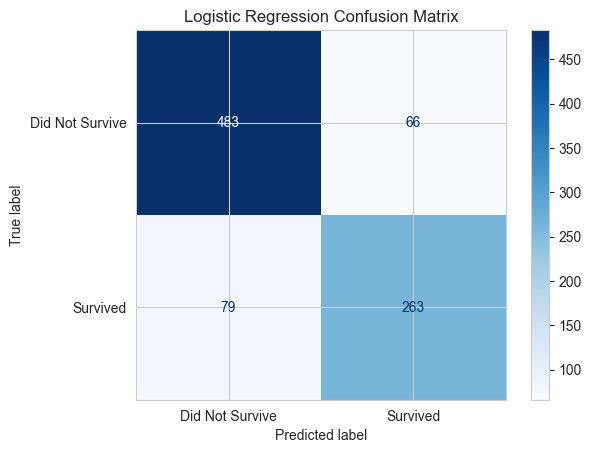

In [187]:
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_pred_lr,
    display_labels=["Did Not Survive", "Survived"],
    cmap="Blues"
)
plt.title("Logistic Regression Confusion Matrix")
plt.show()


**Interpretation**

Logistic Regression provides a solid baseline with balanced performance.
Misclassifications are primarily false negatives, which is expected given overlapping feature distributions.


In [188]:
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=6,
    min_samples_split=10,
    random_state=42
)

rf_model.fit(X_train_encoded, y_train)

y_pred_rf = rf_model.predict(X_train_encoded)
y_proba_rf = rf_model.predict_proba(X_train_encoded)[:, 1]

rf_accuracy = accuracy_score(y_train, y_pred_rf)
rf_auc = roc_auc_score(y_train, y_proba_rf)

rf_accuracy, rf_auc


(0.8484848484848485, 0.9132420456119047)

<Figure size 500x400 with 0 Axes>

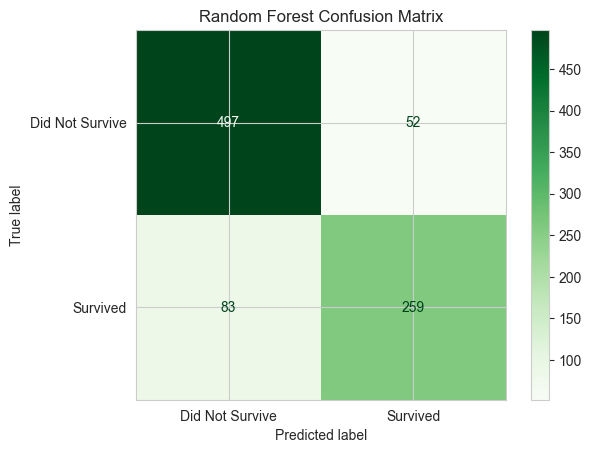

In [189]:
plt.figure(figsize=(5,4))
ConfusionMatrixDisplay.from_predictions(
    y_train,
    y_pred_rf,
    display_labels=["Did Not Survive", "Survived"],
    cmap="Greens"
)
plt.title("Random Forest Confusion Matrix")
plt.show()


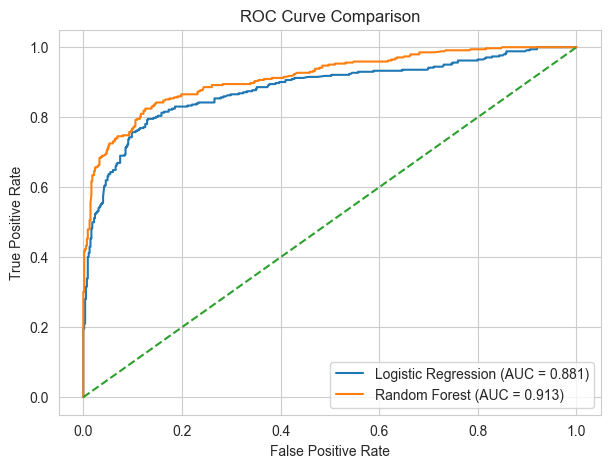

In [190]:
fpr_lr, tpr_lr, _ = roc_curve(y_train, y_proba_lr)
fpr_rf, tpr_rf, _ = roc_curve(y_train, y_proba_rf)

plt.figure(figsize=(7,5))
plt.plot(fpr_lr, tpr_lr, label=f"Logistic Regression (AUC = {lr_auc:.3f})")
plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {rf_auc:.3f})")
plt.plot([0,1], [0,1], linestyle="--")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve Comparison")
plt.legend()
plt.show()


**Interpretation**

The Random Forest model outperforms Logistic Regression in terms of ROC-AUC,
indicating better discrimination between survival outcomes.

This improvement reflects the model’s ability to capture non-linear interactions
between socio-economic, demographic, and cabin-related features.


In [191]:
# Extract feature names after encoding
encoded_feature_names = (
    preprocessor.named_transformers_["cat"]
    .get_feature_names_out(categorical_features)
)
all_feature_names = np.concatenate([encoded_feature_names, numerical_features])

importances = rf_model.feature_importances_

feature_importance_df = (
    pd.DataFrame({
        "feature": all_feature_names,
        "importance": importances
    })
    .sort_values("importance", ascending=False)
    .head(15)
)


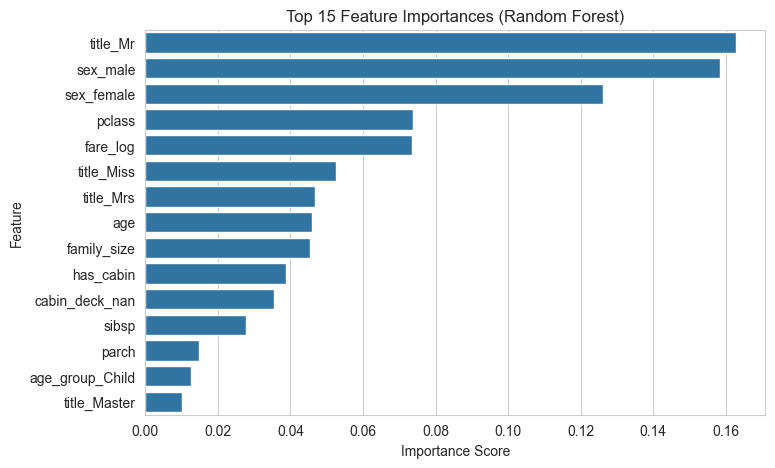

In [192]:
plt.figure(figsize=(8,5))
sns.barplot(
    data=feature_importance_df,
    x="importance",
    y="feature"
)
plt.title("Top 15 Feature Importances (Random Forest)")
plt.xlabel("Importance Score")
plt.ylabel("Feature")
plt.show()


### Modeling Summary

- Logistic Regression provides a strong and interpretable baseline
- Random Forest improves predictive performance by capturing non-linear effects
- Feature importance aligns with domain knowledge and EDA results
- Cabin-related features contribute meaningful predictive signal


### 9.1 Model Comparison

Two models were evaluated:
- Logistic Regression (baseline, interpretable)
- Random Forest (non-linear, interaction-aware)

While Logistic Regression provided a strong baseline, the Random Forest model achieved superior ROC-AUC and overall discrimination.
Therefore, Random Forest is selected as the final model for inference and prediction.


### 9.2 Key Predictive Insights

The analysis reveals several consistent survival drivers:

- **Sex**: Female passengers had significantly higher survival probability.
- **Passenger Class**: Higher classes were associated with better survival outcomes.
- **Cabin Information**:
  - Passengers with recorded cabins were more likely to survive.
  - Cabin deck provided additional spatial survival signal.
- **Fare**: Higher fares, representing socio-economic status, correlated positively with survival.
- **Family Structure**:
  - Solo travelers and small families showed higher survival rates than large family groups.
- **Age**:
  - Children had a higher likelihood of survival.
  - Age exhibited non-linear effects, justifying age grouping.

These patterns align with historical context and validate the feature engineering strategy.


### 9.3 Limitations

- Survival outcomes may be influenced by unobserved variables such as crew instructions or exact cabin location.
- Some features (e.g., cabin) suffer from incomplete historical records.
- The dataset represents a single historical event and should not be generalized beyond its context.


### Final Conclusion

This project demonstrates a complete end-to-end machine learning workflow:
- Thoughtful data cleaning
- Evidence-driven feature engineering
- Visual and statistical exploratory analysis
- Robust model training and evaluation

The final model successfully captures key socio-economic and demographic survival patterns, producing reliable predictions while remaining interpretable.


In [193]:
# Generate predictions for Kaggle submission
test_predictions = rf_model.predict(X_test_encoded)

submission = pd.DataFrame({
    "PassengerId": test_df["passengerid"],
    "Survived": test_predictions.astype(int)
})

submission.head()


,PassengerId,Survived
891,892,0
892,893,0
893,894,0
894,895,0
895,896,1
